In [1]:
import json
import numpy as np
from collections import Counter
import os
import json
import pickle

In [2]:
def load_results_from_pkl(filename):
    # load from pickle file
    assert os.path.isfile(filename)
    with open(filename, "rb") as f:
        results = pickle.load(f)
    return results

In [6]:
def load_results_from_json(filename):
    assert os.path.isfile(filename)
    with open(filename, "r") as f:
        results = json.load(f)
    # for activity net external classification scores
    if 'results' in results:
        results = results['results']
    return results

In [7]:
result1 = load_results_from_pkl("/Users/htp/Desktop/COMP66090 Implement/result_epic.pickle")
print(result1.keys())

dict_keys(['video-id', 't-start', 't-end', 'label', 'score'])


In [8]:
def results_to_dict(results):
    """convert result arrays into dict used by json files"""
    # video ids and allocate the dict
    vidxs = sorted(list(set(results['video-id'])))
    results_dict = {}
    for vidx in vidxs:
        results_dict[vidx] = []

    # fill in the dict
    for vidx, start, end, label, score in zip(
        results['video-id'],
        results['t-start'],
        results['t-end'],
        results['label'],
        results['score']
    ):
        results_dict[vidx].append(
            {
                "label" : int(label),
                "score" : float(score),
                "segment": [float(start), float(end)],
            }
        )
    return results_dict

In [9]:
results_dict1 = results_to_dict(result1)
# print(results_dict1)
# print(results_dict1.keys())
# print(results_dict1["P01_11"])

In [10]:
def results_to_array(results, num_pred):
    # video ids and allocate the dict
    vidxs = sorted(list(set(results['video-id'])))
    results_dict = {}
    for vidx in vidxs:
        results_dict[vidx] = {
            'label'   : [],
            'score'   : [],
            'segment' : [],
        }

    # fill in the dict
    for vidx, start, end, label, score in zip(
        results['video-id'],
        results['t-start'],
        results['t-end'],
        results['label'],
        results['score']
    ):
        results_dict[vidx]['label'].append(int(label))
        results_dict[vidx]['score'].append(float(score))
        results_dict[vidx]['segment'].append(
            [float(start), float(end)]
        )

    for vidx in vidxs:
        label = np.asarray(results_dict[vidx]['label'])
        score = np.asarray(results_dict[vidx]['score'])
        segment = np.asarray(results_dict[vidx]['segment'])

        # the score should be already sorted, just for safety
        inds = np.argsort(score)[::-1][:num_pred]
        label, score, segment = label[inds], score[inds], segment[inds]
        results_dict[vidx]['label'] = label
        results_dict[vidx]['score'] = score
        results_dict[vidx]['segment'] = segment

    return results_dict

In [11]:
results_dict = results_to_array(result1, 200)

labels = results_dict["P01_11"]["label"]
segments = results_dict["P01_11"]["segment"]

# 将 labels 和 segments 按照 segments 的第一个元素进行排序
sorted_pairs = sorted(zip(labels, segments), key=lambda x: x[1][0])

intervals = []

for label, segment in sorted_pairs:
    # print(segment)
    intervals.append([label, list(segment)])

# # 打印排序后的结果
# for label, segment in sorted_pairs:
#     print(label, segment)



In [12]:
for i in intervals:
    print(i)

[2, [0.6616898775100708, 2.990630626678467]]
[91, [3.632143259048462, 13.844977378845215]]
[91, [14.327412605285645, 15.963433265686035]]
[91, [17.060523986816406, 31.993457794189453]]
[91, [36.205204010009766, 42.18081283569336]]
[91, [41.3524055480957, 42.96430969238281]]
[91, [42.93954086303711, 45.86973190307617]]
[36, [51.62517166137695, 53.11598205566406]]
[36, [52.96908187866211, 53.53253936767578]]
[35, [53.536678314208984, 55.77125549316406]]
[35, [55.190067291259766, 57.11970901489258]]
[35, [56.48455047607422, 60.225894927978516]]
[35, [59.21993637084961, 60.60969924926758]]
[35, [60.46230697631836, 61.0693359375]]
[35, [60.935264587402344, 61.80385208129883]]
[35, [61.503318786621094, 63.70044708251953]]
[20, [62.41499710083008, 64.05845642089844]]
[17, [64.76130676269531, 66.26726531982422]]
[2, [67.1374282836914, 68.9653549194336]]
[2, [69.6126480102539, 71.2232894897461]]
[2, [70.6585693359375, 72.07672882080078]]
[17, [72.40657806396484, 73.25662231445312]]
[17, [72.799

In [14]:
def merge_intervals(intervals):
    if not intervals:
        return []

    merged_intervals = []
    current_label, current_segment = intervals[0]

    for label, segment in intervals[1:]:
        if label == current_label:
            current_segment[1] = max(current_segment[1], segment[1])
        else:
            merged_intervals.append([current_label, current_segment])
            current_label = label
            current_segment = segment

    merged_intervals.append([current_label, current_segment])
    return merged_intervals

result = merge_intervals(intervals)
result

[[2, [0.6616898775100708, 2.990630626678467]],
 [91, [3.632143259048462, 45.86973190307617]],
 [36, [51.62517166137695, 53.53253936767578]],
 [35, [53.536678314208984, 63.70044708251953]],
 [20, [62.41499710083008, 64.05845642089844]],
 [17, [64.76130676269531, 66.26726531982422]],
 [2, [67.1374282836914, 72.07672882080078]],
 [17, [72.40657806396484, 79.97795867919922]],
 [6, [81.32807922363281, 82.5205307006836]],
 [21, [81.89580535888672, 84.1330337524414]],
 [2, [95.22874450683594, 96.47599792480469]],
 [91, [97.13404083251953, 111.20597839355469]],
 [4, [111.51065826416016, 113.00084686279297]],
 [14, [112.17247009277344, 113.96367645263672]],
 [4, [112.53791046142578, 113.99706268310547]],
 [2, [112.81291198730469, 114.13265991210938]],
 [6, [114.6900634765625, 117.28553771972656]],
 [21, [115.8403549194336, 117.38706970214844]],
 [2, [117.94755554199219, 119.162353515625]],
 [0, [121.11229705810547, 122.79350280761719]],
 [11, [121.36604309082031, 123.5166015625]],
 [1, [123.542

In [15]:
a = []

for i in result:
    a.append(((i[1][0]+i[1][1])/2))
    
print(len(a))
print(a)

113
[1.8261602520942688, 24.750937581062317, 52.57885551452637, 58.61856269836426, 63.23672676086426, 65.51428604125977, 69.6070785522461, 76.19226837158203, 81.9243049621582, 83.01441955566406, 95.85237121582031, 104.17000961303711, 112.25575256347656, 113.06807327270508, 113.26748657226562, 113.47278594970703, 115.98780059814453, 116.61371231079102, 118.5549545288086, 121.95289993286133, 122.44132232666016, 124.31732940673828, 125.52587127685547, 128.23274993896484, 130.88787078857422, 131.67625427246094, 138.17484283447266, 141.84561920166016, 145.45922088623047, 150.67178344726562, 161.37703704833984, 173.21085357666016, 179.21746826171875, 181.36129760742188, 194.10860443115234, 210.26433563232422, 211.28240966796875, 214.36177825927734, 215.45782470703125, 217.18514251708984, 222.96521759033203, 226.40072631835938, 229.1955795288086, 237.55057525634766, 237.75894165039062, 242.92168426513672, 242.9396743774414, 245.11968994140625, 245.9974594116211, 251.61764526367188, 254.703102

In [16]:
sub = []

for i in result:
    sub.append(i[1])
    
print(len(sub))
print(sub)

113
[[0.6616898775100708, 2.990630626678467], [3.632143259048462, 45.86973190307617], [51.62517166137695, 53.53253936767578], [53.536678314208984, 63.70044708251953], [62.41499710083008, 64.05845642089844], [64.76130676269531, 66.26726531982422], [67.1374282836914, 72.07672882080078], [72.40657806396484, 79.97795867919922], [81.32807922363281, 82.5205307006836], [81.89580535888672, 84.1330337524414], [95.22874450683594, 96.47599792480469], [97.13404083251953, 111.20597839355469], [111.51065826416016, 113.00084686279297], [112.17247009277344, 113.96367645263672], [112.53791046142578, 113.99706268310547], [112.81291198730469, 114.13265991210938], [114.6900634765625, 117.28553771972656], [115.8403549194336, 117.38706970214844], [117.94755554199219, 119.162353515625], [121.11229705810547, 122.79350280761719], [121.36604309082031, 123.5166015625], [123.54293060302734, 125.09172821044922], [123.88799285888672, 127.16374969482422], [126.31765747070312, 130.14784240722656], [130.4530029296875,

In [17]:
import re

def format_time(seconds):
    """Convert seconds to SRT time format."""
    hrs, secs = divmod(seconds, 3600)
    mins, secs = divmod(secs, 60)
    millisecs = int((seconds - int(seconds)) * 1000)
    return f"{int(hrs):02}:{int(mins):02}:{int(secs):02},{millisecs:03}"

def read_and_convert_to_srt(input_file, output_file, interval=2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    srt_entries = []
    start_time = 0.0

    for index, line in enumerate(lines):
        start = format_time(start_time)
        end = format_time(start_time + interval)

        entry = f"{index + 1}\n{start} --> {end}\n{line.strip()}\n\n"
        srt_entries.append(entry)
        
        start_time += interval

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(srt_entries)

# Specify input and output file names
input_file = '/Users/htp/Desktop/captions.txt'
output_file = '/Users/htp/Desktop/output.srt'

# Convert the text file to SRT
read_and_convert_to_srt(input_file, output_file)


In [18]:
def format_time(seconds):
    """Convert seconds to SRT time format."""
    hrs, secs = divmod(seconds, 3600)
    mins, secs = divmod(secs, 60)
    millisecs = int((seconds - int(seconds)) * 1000)
    return f"{int(hrs):02}:{int(mins):02}:{int(secs):02},{millisecs:03}"

def read_subtitles(input_file):
    """Read subtitles from a text file."""
    with open(input_file, 'r', encoding='utf-8') as file:
        subtitles = file.readlines()
    return [subtitle.strip() for subtitle in subtitles]

def convert_to_srt_from_intervals(intervals, subtitles, output_file):
    srt_entries = []

    for index, (interval, subtitle) in enumerate(zip(intervals, subtitles)):
        start, end = interval
        start_time = format_time(start)
        end_time = format_time(end)

        entry = f"{index + 1}\n{start_time} --> {end_time}\n{subtitle}\n\n"
        srt_entries.append(entry)

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(srt_entries)

# Intervals array
intervals = sub

# Read subtitles from input file
input_file = '/Users/htp/Desktop/captions.txt'
subtitles = read_subtitles(input_file)

# Output file name
output_file = '/Users/htp/Desktop/output.srt'

# Convert intervals and subtitles to SRT
convert_to_srt_from_intervals(intervals, subtitles, output_file)


In [19]:
import re

def format_time(seconds):
    """Convert seconds to SRT time format."""
    hrs, secs = divmod(seconds, 3600)
    mins, secs = divmod(secs, 60)
    millisecs = int((seconds - int(seconds)) * 1000)
    return f"{int(hrs):02}:{int(mins):02}:{int(secs):02},{millisecs:03}"

def read_subtitles(input_file):
    """Read subtitles from a text file."""
    subtitles = []
    pattern = re.compile(r'<start>(.*?)<end>')
    
    with open(input_file, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                subtitles.append(match.group(1).strip())
    
    return subtitles

def convert_to_srt_from_intervals(intervals, subtitles, output_file):
    srt_entries = []

    for index, (interval, subtitle) in enumerate(zip(intervals, subtitles)):
        start, end = interval
        start_time = format_time(start)
        end_time = format_time(end)

        entry = f"{index + 1}\n{start_time} --> {end_time}\n{subtitle}\n\n"
        srt_entries.append(entry)

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(srt_entries)

# Intervals array
intervals = sub

# Read subtitles from input file
input_file = '/Users/htp/Desktop/captions.txt'
subtitles = read_subtitles(input_file)

# Output file name
output_file = '/Users/htp/Desktop/output.srt'

# Convert intervals and subtitles to SRT
convert_to_srt_from_intervals(intervals, subtitles, output_file)


In [ ]:
import cv2
import os

# Define the video file path
video_path = 'your_video.mp4'  # Replace with your video file path

# Define the output directory
output_dir = 'extracted_frames'
os.makedirs(output_dir, exist_ok=True)

# Define the timestamps
timestamps = [1.8261602520942688, 24.750937581062317, 52.57885551452637, 58.61856269836426, 
              63.23672676086426, 65.51428604125977, 69.6070785522461, 76.19226837158203, 
              81.9243049621582, 83.01441955566406, 95.85237121582031, 104.17000961303711]

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the frames per second (fps) of the video
fps = cap.get(cv2.CAP_PROP_FPS)

for timestamp in timestamps:
    # Set the frame position
    frame_number = int(fps * timestamp)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    if ret:
        # Construct the output file path
        output_path = os.path.join(output_dir, f'frame_{timestamp:.2f}.jpg')
        
        # Save the frame as an image
        cv2.imwrite(output_path, frame)
    else:
        print(f"Failed to extract frame at {timestamp} seconds")

# Release the video capture object
cap.release()

print("Frames extracted and saved successfully.")


In [69]:

2000-118
1500-105
1000-90
750-80
500-61
400-55
300-40
250-36
200-30
100-23
75-21
50-19
25-12

13

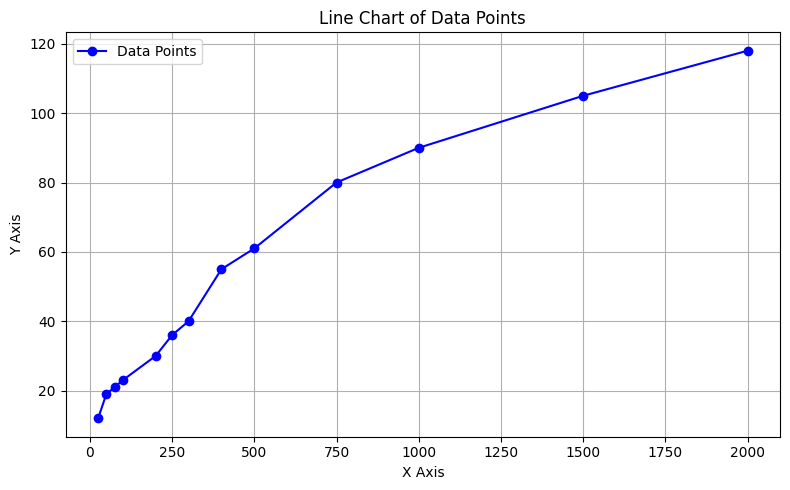

In [76]:
import matplotlib.pyplot as plt

# 数据点
data = [
    (2000, 118),
    (1500, 105),
    (1000, 90),
    (750, 80),
    (500, 61),
    (400, 55),
    (300, 40),
    (250, 36),
    (200, 30),
    (100, 23),
    (75, 21),
    (50, 19),
    (25, 12)
]

# 提取横坐标和纵坐标
x = [point[0] for point in data]
y = [point[1] for point in data]

# 绘制折线图
plt.figure(figsize=(8, 5))  # 设置图形大小，可根据需要调整
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Data Points')  # 设置线型、颜色等
plt.xlabel('X Axis')  # 设置横坐标标签
plt.ylabel('Y Axis')  # 设置纵坐标标签
plt.title('Line Chart of Data Points')  # 设置图表标题
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格线
plt.tight_layout()  # 调整布局，防止标签被切割
plt.show()  # 显示图表


In [12]:
def postprocess_results(results, cls_score_file, num_pred=200, topk=2):

    # load results and convert to dict
    if isinstance(results, str):
        results = load_results_from_pkl(results)
    # array -> dict
    results = results_to_array(results, num_pred)

    # load external classification scores
    if '.json' in cls_score_file:
        cls_scores = load_results_from_json(cls_score_file)
    else:
        cls_scores = load_results_from_pkl(cls_score_file)

    # dict for processed results
    processed_results = {
        'video-id': [],
        't-start' : [],
        't-end': [],
        'label': [],
        'score': []
    }

    # process each video
    for vid, result in results.items():
        # pick top k cls scores and idx
        curr_cls_scores = np.asarray(cls_scores[vid])
        topk_cls_idx = np.argsort(curr_cls_scores)[::-1][:topk]
        topk_cls_score = curr_cls_scores[topk_cls_idx]

        # model outputs
        pred_score, pred_segment, pred_label = \
            result['score'], result['segment'], result['label']
        num_segs = min(num_pred, len(pred_score))

        # duplicate all segment and assign the topk labels
        # K x 1 @ 1 N -> K x N -> KN
        # multiply the scores
        new_pred_score = np.sqrt(topk_cls_score[:, None] @ pred_score[None, :]).flatten()
        new_pred_segment = np.tile(pred_segment, (topk, 1))
        new_pred_label = np.tile(topk_cls_idx[:, None], (1, num_segs)).flatten()

        # add to result
        processed_results['video-id'].extend([vid]*num_segs*topk)
        processed_results['t-start'].append(new_pred_segment[:, 0])
        processed_results['t-end'].append(new_pred_segment[:, 1])
        processed_results['label'].append(new_pred_label)
        processed_results['score'].append(new_pred_score)

    processed_results['t-start'] = np.concatenate(processed_results['t-start'], axis=0)
    processed_results['t-end'] = np.concatenate(processed_results['t-end'], axis=0)
    processed_results['label'] = np.concatenate(processed_results['label'],axis=0)
    processed_results['score'] = np.concatenate(processed_results['score'], axis=0)

    return processed_results

In [27]:
cls_score_file = "/home/featurize/cuhk_val_simp_share.json"
processed_results = postprocess_results(result1, cls_score_file, 2, 2)

In [28]:
print(processed_results.keys())

dict_keys(['video-id', 't-start', 't-end', 'label', 'score'])


In [35]:
counter = Counter(processed_results['video-id'])

# print(counter)

In [36]:
# print(processed_results['video-id'])

In [29]:
print(len(processed_results['label']))
print(len(processed_results['score']))

19704
19704
